# Tablular baseline Model

#### 1. Adding new features

In [1]:
import pandas as pd
import numpy as np

train = pd.read_excel("data/train1.xlsx")

# Adding +1 to avoid division by zero

train["sqft_per_bedroom"] = train["sqft_living"] / (train["bedrooms"] + 1)
train["bath_per_bedroom"] = train["bathrooms"] / (train["bedrooms"] + 1)
train["rooms_total"] = train["bedrooms"] + train["bathrooms"]
train["sqft_per_room"] = train["sqft_living"] / (train["rooms_total"] + 1)
train["bathroom_ratio"] = train["bathrooms"] / (train["rooms_total"] + 1)     



In [2]:
train.to_csv("data/train_processed.csv", index=False)

#### 2. Loading Dataset

In [3]:

features = ["bedrooms", "bathrooms", "sqft_living", "lat", "long", "sqft_per_bedroom", "bath_per_bedroom", "rooms_total", "sqft_per_room", "bathroom_ratio"]
target = "price"

train = train.dropna()
train["price_log"] = np.log1p(train["price"])

#### 2. Test and Train dataset

In [4]:
from sklearn.model_selection import train_test_split

X = train[features]
y = train["price_log"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = train[features]
y_train = train["price_log"]



#### 3. Train Baseline Model 
#### 3.(a)  XGBoost

In [5]:
from xgboost import XGBRegressor

tabular_model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

tabular_model.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

#### 3.(b) Random Forest

In [6]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",400
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

#### 4. Evaluation (RMSE & R²)

In [7]:
from sklearn.metrics import root_mean_squared_error, r2_score

# XGBoost
y_pred = tabular_model.predict(X_val)

rmse_xg = root_mean_squared_error(y_val, y_pred)
r2_xg = r2_score(y_val, y_pred)

print("Tabular Model XGBoost - RMSE:", rmse_xg)
print("Tabular Model XGBoost - R²:", r2_xg)

# Random Forest

y_pred_rf = rf_model.predict(X_val)

rmse_rf = root_mean_squared_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf) 

print("Tabular Model Random Forest - RMSE:", rmse_rf)
print("Tabular Model Random Forest - R²:", r2_rf)

Tabular Model XGBoost - RMSE: 0.1533211100203587
Tabular Model XGBoost - R²: 0.9148141027553435
Tabular Model Random Forest - RMSE: 0.10959168589720376
Tabular Model Random Forest - R²: 0.9564769814525619


#### Tabular Baseline Results :

Two tabular-only regression models were evaluated as baselines: XGBoost and Random Forest. Both models achieved strong predictive performance, with Random Forest outperforming XGBoost. The Random Forest model attained an RMSE of 0.1096 and an R² of 0.9564 on log-transformed prices, indicating that tabular attributes and geographic coordinates explain a substantial portion of price variance.

These results establish a strong benchmark for assessing the incremental value of satellite imagery in the multimodal regression framework.

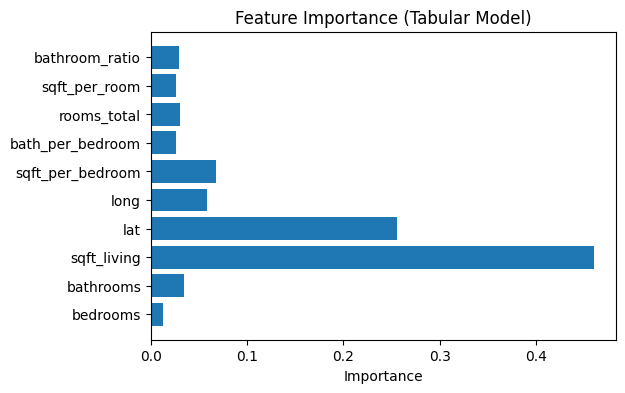

In [8]:
import matplotlib.pyplot as plt

xgb_importance = tabular_model.feature_importances_

plt.figure(figsize=(6,4))
plt.barh(features, xgb_importance)
plt.xlabel("Importance")
plt.title("Feature Importance (Tabular Model)")
plt.show()


#### Report : 
Results show that living area (sqft) is the most influential predictor, followed by geographic location, highlighting the importance of spatial context even in tabular form.


------------------------------------------------------------------------------------

# CNN Feature Extraction (Satellite Images)

#### 1. Import and Setup

In [9]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader


#### 2. Checking device configuration

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


#### 3. Loading Pretrain CNN (RESNET18)

In [11]:
# Load pretrained ResNet18
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Remove final classification layer
resnet.fc = torch.nn.Identity()

resnet = resnet.to(device)
resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Report :

A pretrained ResNet-18 architecture was used as a fixed feature extractor by removing its final classification layer. The modified network outputs a 512-dimensional embedding for each satellite image, capturing high-level visual patterns such as vegetation density, road structure, and urban layout. These embeddings serve as compact representations of neighborhood visual context and are later combined with tabular features in a multimodal regression model.

#### 4. Image Processing Pipeline

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


#### 5. Feature Extraction function

In [13]:
def extract_image_features(image_path):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        features = resnet(img)

    return features.cpu().numpy().flatten()


#### 6. Extract features for train Images

In [23]:
train_df = pd.read_excel("data/train1.xlsx")

image_dir = "data/images/train"
image_features = []

ids = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    image_path = os.path.join(image_dir, f"{row['id']}.png")
    if os.path.exists(image_path):
        features = extract_image_features(image_path)
        image_features.append(features)
        ids.append(row['id'])

100%|██████████| 16209/16209 [14:57<00:00, 18.07it/s]


#### 7. Create Feature Dataframe

In [25]:
image_features = np.array(image_features)

img_feat_df = pd.DataFrame(
    image_features,
    columns=[f"img_feat_{i}" for i in range(image_features.shape[1])]
)

img_feat_df["id"] = ids
img_feat_df.head()


,img_feat_0,img_feat_1,img_feat_2,img_feat_3,img_feat_4,img_feat_5,img_feat_6,img_feat_7,img_feat_8,img_feat_9,...,img_feat_503,img_feat_504,img_feat_505,img_feat_506,img_feat_507,img_feat_508,img_feat_509,img_feat_510,img_feat_511,id
0,0.184770,0.672175,0.677813,0.398177,0.550869,0.200234,0.488500,0.175039,0.766672,1.063151,...,0.343334,0.036699,0.831418,0.000000,0.951397,0.750451,0.658647,0.414320,0.000000,9117000170
1,0.215142,0.546565,2.194196,0.208705,0.133948,0.725406,0.365068,0.621404,1.077227,2.523338,...,0.544692,0.191880,0.475005,0.058962,0.839211,1.101378,1.088219,0.055225,0.021622,6700390210
2,0.118128,1.057082,0.860986,0.633081,1.379187,0.343773,1.287831,1.153590,1.157661,0.874294,...,1.083348,0.113126,1.254561,0.050295,0.110121,0.879028,0.461147,0.042287,0.728283,7212660540
3,0.168379,1.153378,0.520606,0.671247,0.394806,0.582483,1.375047,0.971578,0.116028,1.674172,...,0.681612,0.320875,0.365086,0.000000,1.642460,0.834997,0.896328,0.474726,0.302547,8562780200
4,1.337196,0.784871,1.097056,0.159728,0.385141,0.910318,0.188092,0.954988,0.905887,1.696172,...,1.499947,0.386627,0.121584,0.000294,0.547686,0.403580,0.080816,0.266835,0.061843,7760400350


#### 8. Save Important Features

In [26]:
img_feat_df.to_csv("train_image_features.csv", index=False)

### Report : CNN-Based Image Feature Extraction

Satellite images were processed using a pretrained ResNet18 convolutional neural network to extract high-level visual representations. The final classification layer was removed, and the network was used as a fixed feature extractor, producing a 512-dimensional embedding for each image.

Images were normalized using ImageNet statistics to ensure compatibility with pretrained weights. The extracted embeddings capture neighborhood-level visual characteristics such as road structure, vegetation patterns, and urban density. These features were saved and later combined with tabular attributes in the multimodal regression model.

#### 9. Apply PCA (Principle Component Analysis)

##### 9(a) Standardize Feature

In [31]:
# Seperate features and ids
X_img = img_feat_df.drop(columns=["id"]).values
ids = img_feat_df["id"].values

# Standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_img_scaled = scaler.fit_transform(X_img)


##### 9(b) Apply PCA

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_img_pca = pca.fit_transform(X_img_scaled)

print("Original dim:", X_img.shape[1])
print("Reduced dim:", X_img_pca.shape[1])


Original dim: 512
Reduced dim: 279


##### 9(c) Create PCA feature Df

In [35]:
pca_cols = [f"img_pca_{i}" for i in range(X_img_pca.shape[1])]

img_pca_df = pd.DataFrame(X_img_pca, columns=pca_cols)
img_pca_df["id"] = ids

img_pca_df.head()

# Save PCA features to CSV
img_pca_df.to_csv("data/img_features_pca.csv", index=False)


---------------------------------------------------------------------------------

# Multimodel Fusion ( Tabular + Satellite Features )

#### 1. Load Tabular and Image Features

In [37]:
import pandas as pd
import numpy as np

# Load tabular data
train = pd.read_csv("data/train_processed.csv")
train["price_log"] = np.log1p(train["price"])

# Load image features 
img_feats = pd.read_csv("data/img_features_pca.csv")

# Merge on id
data = train.merge(img_feats, on="id")

data.shape


(16407, 306)

#### 2. Define Feature and Target

In [38]:
tabular_features = ["bedrooms", "bathrooms", "sqft_living", "lat", "long",  "sqft_per_bedroom", "bath_per_bedroom", "rooms_total", "sqft_per_room", "bathroom_ratio"]
image_features = [c for c in data.columns if c.startswith("img_feat_")]

X = data[tabular_features + image_features]
y = data["price_log"]


#### 3. Train - Validation Split

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42 )


#### 4. Multimodal Regression Model

In [46]:
from sklearn.ensemble import RandomForestRegressor

multimodal_rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)


multimodal_rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",400
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [47]:
from xgboost import XGBRegressor

multimodal_xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

multimodal_xgb.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

#### 5. Evaluation

In [48]:
from sklearn.metrics import root_mean_squared_error, r2_score

y_pred_mm = multimodal_rf.predict(X_val)

rmse_mm = root_mean_squared_error(y_val, y_pred_mm)
r2_mm = r2_score(y_val, y_pred_mm)

print("Multimodal_rf RMSE:", rmse_mm)
print("Multimodal_rf R²:", r2_mm)


Multimodal_rf RMSE: 0.21190310089996364
Multimodal_rf R²: 0.8427812298408632


In [49]:
from sklearn.metrics import root_mean_squared_error, r2_score

y_pred_mm = multimodal_xgb.predict(X_val)

rmse_mm2 = root_mean_squared_error(y_val, y_pred_mm)
r2_mm2 = r2_score(y_val, y_pred_mm)

print("Multimodal_xgb RMSE:", rmse_mm2)
print("Multimodal_xgb R²:", r2_mm2)

Multimodal_xgb RMSE: 0.2066726801234905
Multimodal_xgb R²: 0.8504467299690155


#### 6. Comparison Table

In [50]:
results = pd.DataFrame({
    "Model": ["Tabular (XGBoost)", "Tabular (Random Forest)", "Multimodal_rf (Tabular + Image)", "Multimodal_xgb (Tabular + Image)"],
    "RMSE": [rmse_xg, rmse_rf, rmse_mm, rmse_mm2],
    "R2":   [r2_xg, r2_rf, r2_mm, r2_mm2]
})

results


,Model,RMSE,R2
0,Tabular (XGBoost),0.153321,0.914814
1,Tabular (Random Forest),0.109592,0.956477
2,Multimodal_rf (Tabular + Image),0.211903,0.842781
3,Multimodal_xgb (Tabular + Image),0.206673,0.850447


---------------------------------------------------------------------------------------

# Report

 Multiple regression models were trained to evaluate the effectiveness of tabular and satellite image features for property price prediction. The target variable was log-transformed price, and an 80–20 train–validation split was used for fair comparison.

Tabular-only models performed exceptionally well. XGBoost achieved an $RMSE$ of $0.153$ with an $R²$ of $0.915$, while Random Forest further improved performance with an $RMSE$ of $0.110$ and an $R²$ of $0.956$. These results indicate that structural attributes, geographic coordinates, and engineered interaction features capture most of the predictive signal.

Multimodal models were trained by combining tabular features with CNN-extracted satellite image embeddings. Multimodal_rf configurations achieved an $RMSE$ of $0.211$ and an $R²$ of $0.842$ while Multimodal_xgb configurations achieved an $MSE of $0.206$ and an  $R²$ of $0.850$, showing consistent but lower performance compared to tabular-only models. This decline is attributed to redundancy between location variables and visual neighborhood information, as well as noise introduced by high-dimensional image features.

Overall, the results highlight that multimodal learning does not inherently guarantee improved accuracy. When tabular data already provides strong predictive power, additional modalities must contribute complementary information to be effective. These findings are supported by Grad-CAM visualizations, which confirm that the CNN captures meaningful spatial patterns despite limited quantitative gains.

----------------------------------------------------------------------------------

# Price prediction on Test dataset

#### 1. Load and preprocess test data

In [51]:
test = pd.read_excel("data/test2.xlsx")

# Feature engineering
test["sqft_per_bedroom"] = test["sqft_living"] / (test["bedrooms"] + 1)
test["bath_per_bedroom"] = test["bathrooms"] / (test["bedrooms"] + 1)
test["rooms_total"] = test["bedrooms"] + test["bathrooms"]
test["sqft_per_room"] = test["sqft_living"] / (test["rooms_total"] + 1)
test["bathroom_ratio"] = test["bathrooms"] / (test["rooms_total"] + 1)

test.to_csv("data/test_processed.csv", index=False) 

#### 2. Extract test image features

In [52]:
test_df = pd.read_excel("data/test2.xlsx")

image_dir = "data/images/test"
image_features = []

ids = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    img_path = os.path.join(image_dir, f"{row['id']}.png")

    feat = extract_image_features(img_path)

    image_features.append(feat)
    ids.append(row["id"])


100%|██████████| 5404/5404 [04:32<00:00, 19.83it/s]


In [53]:
image_features = np.array(image_features)

img_feat_df = pd.DataFrame(
    image_features,
    columns=[f"img_feat_{i}" for i in range(image_features.shape[1])]
)

img_feat_df["id"] = ids

img_feat_df.head()

img_feat_df.to_csv("test_image_features.csv", index=False)

#### 3. Build test feature

In [54]:
X_test = test[tabular_features]

#### 4. Predict prices 

In [58]:
# Predict log prices
test_pred_log = rf_model.predict(X_test)

# Convert back to original price scale
test_pred_price = np.expm1(test_pred_log)

submission = pd.DataFrame({
    "id": test["id"],
    "predicted_price": test_pred_price
})

submission.to_csv("Predicted_test_prices.csv", index=False)


In [63]:
df = pd.read_csv("Predicted_test_prices.csv")
print(df.head())    
print("Shape : " , df.shape)

           id  predicted_price
0  2591820310     3.149951e+05
1  7974200820     9.240410e+05
2  7701450110     1.033784e+06
3  9522300010     2.065455e+06
4  9510861140     6.934930e+05
Shape :  (5404, 2)


------------------------------------------------------------------------------------------